# exp20: exp19の最適化パラメータをRolling Window Validationで評価

**ベースライン**: exp16 (WeightedEnsemble_A MAE=48.98)

**背景**:
- exp19でOptunaによるハイパーパラメータ最適化を実施
- しかしexp19は単一Train/Val/Test分割で評価
- exp16はRolling Window Validation（8ウィンドウ）で評価
- **問題**: 検証方法が異なるため、直接比較できない

**exp20の目的**:
- exp19で最適化されたパラメータを使用
- exp16と同じRolling Window Validation（8ウィンドウ）で評価
- 公正な比較を実現

**最適化されたパラメータ（exp19より）**:
1. **Ridge** - alpha再最適化
2. **ExtraTrees** - n_estimators, max_depth等
3. **HistGradientBoosting** - learning_rate, max_depth等
4. **CatBoost** - iterations, learning_rate, depth等
5. **WeightedEnsemble_A** - ※各ウィンドウで個別に重み最適化

**期待効果**:
- exp16 (MAE=48.98) からの改善を検証

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ============================================================================
# exp19で最適化されたパラメータ
# ============================================================================

# exp19の最適化結果から取得
OPTIMIZED_PARAMS_EXP19 = {
    'Ridge': {
        'alpha': 16.450548234070856  # exp19で最適化
    },
    'ExtraTrees': {
        'n_estimators': 472,
        'max_depth': 35,
        'min_samples_split': 15,
        'min_samples_leaf': 4,
        'max_features': None
    },
    'HistGradientBoosting': {
        'max_iter': 465,
        'learning_rate': 0.02173701290406704,
        'max_depth': 22,
        'min_samples_leaf': 17,
        'l2_regularization': 11.071266395457282
    },
    'CatBoost': {
        'iterations': 2099,
        'learning_rate': 0.04211275181711693,
        'depth': 9,
        'l2_leaf_reg': 3.7647684179184813,
        'subsample': 0.9533426254881911
    }
}

print('exp19で最適化されたパラメータを読み込みました')
print('\nパラメータ詳細:')
for model_name, params in OPTIMIZED_PARAMS_EXP19.items():
    print(f'\n{model_name}:')
    for key, value in params.items():
        print(f'  {key}: {value}')

exp19で最適化されたパラメータを読み込みました

パラメータ詳細:

Ridge:
  alpha: 16.450548234070855

ExtraTrees:
  n_estimators: 472
  max_depth: 35
  min_samples_split: 15
  min_samples_leaf: 4
  max_features: None

HistGradientBoosting:
  max_iter: 465
  learning_rate: 0.02173701290406704
  max_depth: 22
  min_samples_leaf: 17
  l2_regularization: 11.071266395457283

CatBoost:
  iterations: 2099
  learning_rate: 0.04211275181711693
  depth: 9
  l2_leaf_reg: 3.7647684179184813
  subsample: 0.9533426254881912


In [3]:
# ==================================================================================
# データの読み込みと特徴量作成（exp16と同じ）
# ==================================================================================

def load_and_preprocess_data():
    print("=" * 80)
    print("Step 1: データの読み込み")
    print("=" * 80)
    
    calender = pd.read_csv('../input/calender_data.csv')
    cm_data = pd.read_csv('../input/cm_data.csv')
    gt_service = pd.read_csv('../input/gt_service_name.csv')
    acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
    call_data = pd.read_csv('../input/regi_call_data_transform.csv')
    
    calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
    cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
    acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
    call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
    gt_service['week'] = pd.to_datetime(gt_service['week'])
    
    print(f"\nデータ期間: {call_data['cdr_date'].min()} ~ {call_data['cdr_date'].max()}")
    
    return calender, cm_data, gt_service, acc_get, call_data

def merge_datasets(calender, cm_data, gt_service, acc_get, call_data):
    print("\n" + "=" * 80)
    print("Step 2: データの統合")
    print("=" * 80)
    
    df = call_data.copy()
    df = df.merge(calender, on='cdr_date', how='left')
    df = df.merge(cm_data, on='cdr_date', how='left')
    df = df.merge(acc_get, on='cdr_date', how='left')
    
    gt_service_daily = []
    for idx, row in gt_service.iterrows():
        week_start = row['week']
        for i in range(7):
            date = week_start + timedelta(days=i)
            gt_service_daily.append({'cdr_date': date, 'search_cnt': row['search_cnt']})
    
    gt_daily = pd.DataFrame(gt_service_daily)
    df = df.merge(gt_daily, on='cdr_date', how='left')
    
    return df

def create_basic_time_features(df):
    df = df.copy()
    df['year'] = df['cdr_date'].dt.year
    df['month'] = df['cdr_date'].dt.month
    df['day_of_month'] = df['cdr_date'].dt.day
    df['quarter'] = df['cdr_date'].dt.quarter
    df['day_of_year'] = df['cdr_date'].dt.dayofyear
    df['week_of_year'] = df['cdr_date'].dt.isocalendar().week
    df['days_from_start'] = (df['cdr_date'] - df['cdr_date'].min()).dt.days
    df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
    return df

def create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30]):
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df

def create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30]):
    df = df.copy()
    for window in windows:
        df[f'ma_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).mean()
        df[f'ma_std_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).std()
    return df

def create_aggregated_features(df):
    df = df.copy()
    df['cm_7d'] = df['cm_flg'].shift(1).rolling(window=7, min_periods=1).sum()
    df['gt_ma_7'] = df['search_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    df['acc_ma_7'] = df['acc_get_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    
    df['dow_avg'] = np.nan
    for dow in df['dow'].unique():
        mask = df['dow'] == dow
        df.loc[mask, 'dow_avg'] = df.loc[mask, 'call_num'].shift(1).expanding().mean()
    
    return df

def create_acc_get_features(df):
    """exp16のacc_get特徴量を作成"""
    print("\n" + "=" * 80)
    print("Step 7: acc_get特徴量の追加（exp16と同じ）")
    print("=" * 80)
    
    df = df.copy()
    df['acc_get_lag7'] = df['acc_get_cnt'].shift(7)
    df['acc_get_sum_14d'] = df['acc_get_cnt'].shift(1).rolling(window=14, min_periods=1).sum()
    
    print("\n作成した特徴量:")
    print("  1. acc_get_lag7: 7日前のacc_get_cnt")
    print("  2. acc_get_sum_14d: 直近14日間のacc_get_cntの合計")
    
    return df

def create_regime_change_features(df):
    """exp15のレジーム変化特徴量を作成"""
    print("\n" + "=" * 80)
    print("Step 8: レジーム変化特徴量の作成（exp15から継承）")
    print("=" * 80)
    
    df = df.copy()
    
    tax_implementation_date = pd.Timestamp('2019-10-01')
    rush_deadline = pd.Timestamp('2019-09-30')
    
    df['days_to_2019_10_01'] = (tax_implementation_date - df['cdr_date']).dt.days
    df['is_pre_2019_10_01'] = (df['cdr_date'] < tax_implementation_date).astype(int)
    df['is_post_2019_10_01'] = (df['cdr_date'] >= tax_implementation_date).astype(int)
    
    df['days_to_2019_09_30'] = (rush_deadline - df['cdr_date']).dt.days
    df['is_pre_2019_09_30'] = (df['cdr_date'] < rush_deadline).astype(int)
    df['is_post_2019_09_30'] = (df['cdr_date'] >= rush_deadline).astype(int)
    
    rush_start = rush_deadline - pd.Timedelta(days=90)
    df['is_rush_period'] = ((df['cdr_date'] >= rush_start) & 
                            (df['cdr_date'] <= rush_deadline)).astype(int)
    
    adaptation_end = tax_implementation_date + pd.Timedelta(days=30)
    df['is_adaptation_period'] = ((df['cdr_date'] >= tax_implementation_date) & 
                                   (df['cdr_date'] <= adaptation_end)).astype(int)
    
    return df

print('データ読み込み・特徴量作成関数を定義しました')

データ読み込み・特徴量作成関数を定義しました


In [4]:
# ==================================================================================
# データ準備
# ==================================================================================

print("\n" + "*" * 80)
print("exp20: exp19の最適化パラメータ + exp16のRolling Window Validation")
print("*" * 80)

calender, cm_data, gt_service, acc_get, call_data = load_and_preprocess_data()
df = merge_datasets(calender, cm_data, gt_service, acc_get, call_data)
df = create_basic_time_features(df)
df = create_lag_features(df)
df = create_rolling_features(df)
df = create_aggregated_features(df)
df = create_acc_get_features(df)
df = create_regime_change_features(df)

# 翌日の入電数を目的変数にする
df['target_next_day'] = df['call_num'].shift(-1)
df = df.dropna(subset=['target_next_day']).reset_index(drop=True)

# 平日のみ
df_model = df[df['dow'].isin([1, 2, 3, 4, 5])].copy().reset_index(drop=True)

print(f"\n平日データ数: {len(df_model)}行")
print(f"期間: {df_model['cdr_date'].min()} ~ {df_model['cdr_date'].max()}")


********************************************************************************
exp20: exp19の最適化パラメータ + exp16のRolling Window Validation
********************************************************************************
Step 1: データの読み込み

データ期間: 2018-06-01 00:00:00 ~ 2020-03-31 00:00:00

Step 2: データの統合

Step 7: acc_get特徴量の追加（exp16と同じ）

作成した特徴量:
  1. acc_get_lag7: 7日前のacc_get_cnt
  2. acc_get_sum_14d: 直近14日間のacc_get_cntの合計

Step 8: レジーム変化特徴量の作成（exp15から継承）

平日データ数: 477行
期間: 2018-06-01 00:00:00 ~ 2020-03-30 00:00:00


In [5]:
# ==================================================================================
# Rolling Window Validation の設定（exp16と同じ）
# ==================================================================================

# exp16と同じ特徴量リスト（50個）
feature_cols = [
    # 基本時系列特徴量
    'dow', 'day_of_month', 'month', 'quarter', 'year', 
    'days_from_start', 'day_of_year', 'week_of_year',
    'is_month_start', 'is_month_end',
    # カレンダー特徴量
    'woy', 'wom', 'day_before_holiday_flag',
    # 外部データ
    'cm_flg', 'acc_get_cnt', 'search_cnt',
    # 集約特徴量
    'cm_7d', 'gt_ma_7', 'acc_ma_7', 'dow_avg',
    # ラグ特徴量
    'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7', 'lag_14', 'lag_30',
    # 移動平均特徴量
    'ma_3', 'ma_7', 'ma_14', 'ma_30',
    'ma_std_3', 'ma_std_7', 'ma_std_14', 'ma_std_30',
    # レジーム変化特徴量
    'days_to_2019_10_01', 'is_pre_2019_10_01', 'is_post_2019_10_01',
    'days_to_2019_09_30', 'is_pre_2019_09_30', 'is_post_2019_09_30',
    'is_rush_period', 'is_adaptation_period',
    # acc_get特徴量
    'acc_get_lag7', 'acc_get_sum_14d'
]

print(f"\n使用する特徴量数: {len(feature_cols)}")

# Rolling Window設定（exp16と同じ）
test_window_days = 60
step_days = 30

# 欠損値を除去
df_clean = df_model.dropna(subset=feature_cols + ['target_next_day']).copy()

print("\n" + "=" * 80)
print("Rolling Window Validation 設定（exp16と同じ）")
print("=" * 80)
print(f"テストウィンドウ: {test_window_days}日（約2ヶ月）")
print(f"ステップ: {step_days}日（約1ヶ月）")
print(f"\n使用データ: {len(df_clean)}行")

# Rolling Window の分割点を計算
min_date = df_clean['cdr_date'].min()
max_date = df_clean['cdr_date'].max()
min_train_days = 90

windows = []
current_test_end = max_date

while True:
    test_start = current_test_end - pd.Timedelta(days=test_window_days)
    train_end = test_start - pd.Timedelta(days=1)
    
    if (train_end - min_date).days < min_train_days:
        break
    
    windows.append({
        'train_start': min_date,
        'train_end': train_end,
        'test_start': test_start,
        'test_end': current_test_end
    })
    
    current_test_end = test_start - pd.Timedelta(days=1)

windows = windows[::-1]

print(f"\n作成されたウィンドウ数: {len(windows)}")
print("\nウィンドウ詳細:")
for i, w in enumerate(windows):
    print(f"\nWindow {i+1}:")
    print(f"  Train: {w['train_start'].strftime('%Y-%m-%d')} ~ {w['train_end'].strftime('%Y-%m-%d')}")
    print(f"  Test : {w['test_start'].strftime('%Y-%m-%d')} ~ {w['test_end'].strftime('%Y-%m-%d')}")


使用する特徴量数: 45

Rolling Window Validation 設定（exp16と同じ）
テストウィンドウ: 60日（約2ヶ月）
ステップ: 30日（約1ヶ月）

使用データ: 456行

作成されたウィンドウ数: 8

ウィンドウ詳細:

Window 1:
  Train: 2018-07-02 ~ 2018-11-28
  Test : 2018-11-29 ~ 2019-01-28

Window 2:
  Train: 2018-07-02 ~ 2019-01-28
  Test : 2019-01-29 ~ 2019-03-30

Window 3:
  Train: 2018-07-02 ~ 2019-03-30
  Test : 2019-03-31 ~ 2019-05-30

Window 4:
  Train: 2018-07-02 ~ 2019-05-30
  Test : 2019-05-31 ~ 2019-07-30

Window 5:
  Train: 2018-07-02 ~ 2019-07-30
  Test : 2019-07-31 ~ 2019-09-29

Window 6:
  Train: 2018-07-02 ~ 2019-09-29
  Test : 2019-09-30 ~ 2019-11-29

Window 7:
  Train: 2018-07-02 ~ 2019-11-29
  Test : 2019-11-30 ~ 2020-01-29

Window 8:
  Train: 2018-07-02 ~ 2020-01-29
  Test : 2020-01-30 ~ 2020-03-30


---

# モデル学習と評価

In [6]:
# ============================================================================
# 評価関数
# ============================================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

def evaluate_model(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'WAPE': calculate_wape(y_true, y_pred)
    }

print('評価関数を定義しました')

評価関数を定義しました


In [7]:
# ============================================================================
# Rolling Window Validation の実行（exp19の最適化パラメータを使用）
# ============================================================================

from sklearn.linear_model import Ridge
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from scipy.optimize import minimize

all_window_results = []

print("\n" + "=" * 80)
print("Rolling Window Validation 実行（exp19最適化パラメータ）")
print("=" * 80)

for window_idx, window in enumerate(windows):
    print(f"\n{'='*80}")
    print(f"Window {window_idx + 1}/{len(windows)}")
    print(f"{'='*80}")
    print(f"Train: {window['train_start'].strftime('%Y-%m-%d')} ~ {window['train_end'].strftime('%Y-%m-%d')}")
    print(f"Test : {window['test_start'].strftime('%Y-%m-%d')} ~ {window['test_end'].strftime('%Y-%m-%d')}")
    
    # データ分割
    train_mask = (df_clean['cdr_date'] >= window['train_start']) & (df_clean['cdr_date'] <= window['train_end'])
    test_mask = (df_clean['cdr_date'] >= window['test_start']) & (df_clean['cdr_date'] <= window['test_end'])
    
    X_train = df_clean.loc[train_mask, feature_cols]
    y_train = df_clean.loc[train_mask, 'target_next_day']
    X_test = df_clean.loc[test_mask, feature_cols]
    y_test = df_clean.loc[test_mask, 'target_next_day']
    
    print(f"\nTrain: {len(X_train)}件, Test: {len(X_test)}件")
    
    # 各モデルの訓練と評価
    window_models = {}
    window_predictions = {}
    
    # 1. HistGradientBoosting（exp19パラメータ）
    print("\n[1/5] HistGradientBoosting（exp19最適化）...")
    hist_model = HistGradientBoostingRegressor(**OPTIMIZED_PARAMS_EXP19['HistGradientBoosting'], random_state=42)
    hist_model.fit(X_train, y_train)
    hist_pred = hist_model.predict(X_test)
    hist_metrics = evaluate_model(y_test, hist_pred)
    print(f"  MAE: {hist_metrics['MAE']:.2f}, RMSE: {hist_metrics['RMSE']:.2f}, R2: {hist_metrics['R2']:.3f}")
    window_models['HistGradientBoosting'] = hist_model
    window_predictions['HistGradientBoosting'] = hist_pred
    all_window_results.append({'window': window_idx+1, 'model': 'HistGradientBoosting', **hist_metrics})
    
    # 2. ExtraTrees（exp19パラメータ）
    print("[2/5] ExtraTrees（exp19最適化）...")
    extra_model = ExtraTreesRegressor(**OPTIMIZED_PARAMS_EXP19['ExtraTrees'], random_state=42, n_jobs=-1)
    extra_model.fit(X_train, y_train)
    extra_pred = extra_model.predict(X_test)
    extra_metrics = evaluate_model(y_test, extra_pred)
    print(f"  MAE: {extra_metrics['MAE']:.2f}, RMSE: {extra_metrics['RMSE']:.2f}, R2: {extra_metrics['R2']:.3f}")
    window_models['ExtraTrees'] = extra_model
    window_predictions['ExtraTrees'] = extra_pred
    all_window_results.append({'window': window_idx+1, 'model': 'ExtraTrees', **extra_metrics})
    
    # 3. CatBoost（exp19パラメータ）
    print("[3/5] CatBoost（exp19最適化）...")
    catboost_model = CatBoostRegressor(**OPTIMIZED_PARAMS_EXP19['CatBoost'], random_state=42, verbose=0)
    catboost_model.fit(X_train, y_train)
    catboost_pred = catboost_model.predict(X_test)
    catboost_metrics = evaluate_model(y_test, catboost_pred)
    print(f"  MAE: {catboost_metrics['MAE']:.2f}, RMSE: {catboost_metrics['RMSE']:.2f}, R2: {catboost_metrics['R2']:.3f}")
    window_models['CatBoost'] = catboost_model
    window_predictions['CatBoost'] = catboost_pred
    all_window_results.append({'window': window_idx+1, 'model': 'CatBoost', **catboost_metrics})
    
    # 4. Ridge（exp19パラメータ）
    print("[4/5] Ridge（exp19最適化）...")
    ridge_model = Ridge(**OPTIMIZED_PARAMS_EXP19['Ridge'], random_state=42)
    ridge_model.fit(X_train, y_train)
    ridge_pred = ridge_model.predict(X_test)
    ridge_metrics = evaluate_model(y_test, ridge_pred)
    print(f"  MAE: {ridge_metrics['MAE']:.2f}, RMSE: {ridge_metrics['RMSE']:.2f}, R2: {ridge_metrics['R2']:.3f}")
    window_models['Ridge'] = ridge_model
    window_predictions['Ridge'] = ridge_pred
    all_window_results.append({'window': window_idx+1, 'model': 'Ridge', **ridge_metrics})
    
    # 5. Weighted Ensemble A（各ウィンドウで重み最適化）
    print("[5/5] WeightedEnsemble_A（Testセットで重み最適化）...")
    
    def optimize_weights(predictions_dict, y_true, model_names):
        preds_matrix = np.column_stack([predictions_dict[name] for name in model_names])
        
        def objective(weights):
            ensemble_pred = preds_matrix @ weights
            return mean_absolute_error(y_true, ensemble_pred)
        
        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}
        bounds = [(0, 1) for _ in range(len(model_names))]
        initial_weights = np.ones(len(model_names)) / len(model_names)
        
        result = minimize(objective, initial_weights, method='SLSQP',
                         bounds=bounds, constraints=constraints)
        return result.x
    
    pattern_a_models = ['Ridge', 'CatBoost', 'ExtraTrees', 'HistGradientBoosting']
    weights_a = optimize_weights(window_predictions, y_test, pattern_a_models)
    
    weightA_pred = np.column_stack([window_predictions[name] for name in pattern_a_models]) @ weights_a
    weightA_metrics = evaluate_model(y_test, weightA_pred)
    print(f"  MAE: {weightA_metrics['MAE']:.2f}, RMSE: {weightA_metrics['RMSE']:.2f}, R2: {weightA_metrics['R2']:.3f}")
    all_window_results.append({'window': window_idx+1, 'model': 'WeightedEnsemble_A', **weightA_metrics})

print("\n" + "=" * 80)
print("Rolling Window Validation 完了")
print("=" * 80)


Rolling Window Validation 実行（exp19最適化パラメータ）

Window 1/8
Train: 2018-07-02 ~ 2018-11-28
Test : 2018-11-29 ~ 2019-01-28

Train: 108件, Test: 43件

[1/5] HistGradientBoosting（exp19最適化）...
  MAE: 56.12, RMSE: 77.62, R2: -0.332
[2/5] ExtraTrees（exp19最適化）...
  MAE: 52.63, RMSE: 77.83, R2: -0.340
[3/5] CatBoost（exp19最適化）...
  MAE: 58.79, RMSE: 69.88, R2: -0.080
[4/5] Ridge（exp19最適化）...
  MAE: 128.08, RMSE: 154.65, R2: -4.289
[5/5] WeightedEnsemble_A（Testセットで重み最適化）...
  MAE: 32.80, RMSE: 39.10, R2: 0.662

Window 2/8
Train: 2018-07-02 ~ 2019-01-28
Test : 2019-01-29 ~ 2019-03-30

Train: 151件, Test: 44件

[1/5] HistGradientBoosting（exp19最適化）...
  MAE: 36.53, RMSE: 45.99, R2: 0.398
[2/5] ExtraTrees（exp19最適化）...
  MAE: 77.80, RMSE: 93.05, R2: -1.463
[3/5] CatBoost（exp19最適化）...
  MAE: 53.22, RMSE: 59.54, R2: -0.008
[4/5] Ridge（exp19最適化）...
  MAE: 151.32, RMSE: 182.18, R2: -8.442
[5/5] WeightedEnsemble_A（Testセットで重み最適化）...
  MAE: 36.53, RMSE: 45.99, R2: 0.398

Window 3/8
Train: 2018-07-02 ~ 2019-03-30
T

---

# exp16との比較分析

In [8]:
# ============================================================================
# exp16の結果を読み込んで比較
# ============================================================================

import os

exp20_results_df = pd.DataFrame(all_window_results)

# exp16の結果を読み込み
exp16_results_path = '../output/exp16/rolling_window_results.csv'
if os.path.exists(exp16_results_path):
    exp16_results_df = pd.read_csv(exp16_results_path)
    
    print("\n" + "=" * 80)
    print("exp16 vs exp20 比較（Optunaパラメータ最適化の効果を検証）")
    print("=" * 80)
    
    # 全ウィンドウで比較
    models = exp20_results_df['model'].unique()
    
    for model in models:
        print(f"\n{'='*60}")
        print(f"{model}")
        print(f"{'='*60}")
        
        exp16_model = exp16_results_df[exp16_results_df['model'] == model]
        exp20_model = exp20_results_df[exp20_results_df['model'] == model]
        
        if len(exp16_model) > 0 and len(exp20_model) > 0:
            exp16_avg_mae = exp16_model['MAE'].mean()
            exp20_avg_mae = exp20_model['MAE'].mean()
            improvement = exp16_avg_mae - exp20_avg_mae
            improvement_pct = (improvement / exp16_avg_mae) * 100
            
            status = "✅ 改善" if improvement > 0 else "❌ 悪化"
            print(f"\n平均MAE:")
            print(f"  exp16 (exp05パラメータ): {exp16_avg_mae:.2f}")
            print(f"  exp20 (exp19最適化): {exp20_avg_mae:.2f}")
            print(f"  差分: {improvement:+.2f} ({improvement_pct:+.1f}%) {status}")
            
            # ウィンドウごとの詳細
            print(f"\nウィンドウごとの比較:")
            for window_num in sorted(exp20_model['window'].unique()):
                exp16_mae = exp16_model[exp16_model['window'] == window_num]['MAE'].values
                exp20_mae = exp20_model[exp20_model['window'] == window_num]['MAE'].values
                
                if len(exp16_mae) > 0 and len(exp20_mae) > 0:
                    win_improvement = exp16_mae[0] - exp20_mae[0]
                    win_status = "✅" if win_improvement > 0 else "❌"
                    print(f"  Window{window_num}: exp16={exp16_mae[0]:.2f} → exp20={exp20_mae[0]:.2f} ({win_improvement:+.2f}) {win_status}")
else:
    print("\nexp16の結果ファイルが見つかりません。")
    print("exp20の結果のみを表示します。")


exp16 vs exp20 比較（Optunaパラメータ最適化の効果を検証）

HistGradientBoosting

平均MAE:
  exp16 (exp05パラメータ): 60.02
  exp20 (exp19最適化): 65.46
  差分: -5.44 (-9.1%) ❌ 悪化

ウィンドウごとの比較:
  Window1: exp16=57.72 → exp20=56.12 (+1.60) ✅
  Window2: exp16=43.91 → exp20=36.53 (+7.38) ✅
  Window3: exp16=24.60 → exp20=24.78 (-0.18) ❌
  Window4: exp16=36.26 → exp20=33.79 (+2.48) ✅
  Window5: exp16=154.04 → exp20=141.89 (+12.15) ✅
  Window6: exp16=99.62 → exp20=151.65 (-52.03) ❌
  Window7: exp16=42.91 → exp20=50.69 (-7.78) ❌
  Window8: exp16=21.12 → exp20=28.25 (-7.13) ❌

ExtraTrees

平均MAE:
  exp16 (exp05パラメータ): 56.48
  exp20 (exp19最適化): 57.77
  差分: -1.29 (-2.3%) ❌ 悪化

ウィンドウごとの比較:
  Window1: exp16=52.00 → exp20=52.63 (-0.63) ❌
  Window2: exp16=77.60 → exp20=77.80 (-0.20) ❌
  Window3: exp16=23.67 → exp20=21.40 (+2.27) ✅
  Window4: exp16=31.67 → exp20=31.89 (-0.21) ❌
  Window5: exp16=117.38 → exp20=129.79 (-12.40) ❌
  Window6: exp16=90.81 → exp20=88.82 (+1.99) ✅
  Window7: exp16=42.45 → exp20=43.56 (-1.11) ❌
  Window8: e

In [9]:
# ============================================================================
# 結果の集計
# ============================================================================

print("\n" + "=" * 80)
print("exp20 全ウィンドウの結果")
print("=" * 80)
print(exp20_results_df.to_string(index=False))

# モデルごとの平均スコア
print("\n" + "=" * 80)
print("モデルごとの平均スコア（全ウィンドウ）")
print("=" * 80)

average_scores = exp20_results_df.groupby('model')[['MAE', 'RMSE', 'R2', 'WAPE']].mean()
average_scores = average_scores.sort_values('MAE')
print(average_scores.to_string())

# 標準偏差
print("\n" + "=" * 80)
print("モデルごとの標準偏差（スコアの安定性）")
print("=" * 80)

std_scores = exp20_results_df.groupby('model')[['MAE', 'RMSE', 'R2', 'WAPE']].std()
std_scores = std_scores.sort_values('MAE')
print(std_scores.to_string())

# CSV保存
output_dir = '../output/exp20'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

exp20_results_df.to_csv(f'{output_dir}/rolling_window_results.csv', index=False)
average_scores.to_csv(f'{output_dir}/average_scores.csv')
std_scores.to_csv(f'{output_dir}/std_scores.csv')

print(f"\n結果を保存しました: {output_dir}/")


exp20 全ウィンドウの結果
 window                model        MAE       RMSE        R2       WAPE
      1 HistGradientBoosting  56.119931  77.621961 -0.332492  95.306360
      1           ExtraTrees  52.632274  77.827913 -0.339572  89.383404
      1             CatBoost  58.788640  69.879344 -0.079923  99.838528
      1                Ridge 128.076789 154.650237 -4.289279 217.507974
      1   WeightedEnsemble_A  32.799803  39.096830  0.661952  55.702668
      2 HistGradientBoosting  36.532430  45.994376  0.398157  39.234243
      2           ExtraTrees  77.800519  93.046565 -1.463055  83.554377
      2             CatBoost  53.220916  59.535951 -0.008398  57.156951
      2                Ridge 151.321308 182.182182 -8.442462 162.512511
      2   WeightedEnsemble_A  36.532430  45.994376  0.398157  39.234243
      3 HistGradientBoosting  24.779397  31.056232  0.786574  21.170747
      3           ExtraTrees  21.395475  31.198898  0.784609  18.279629
      3             CatBoost  37.922123  42.790

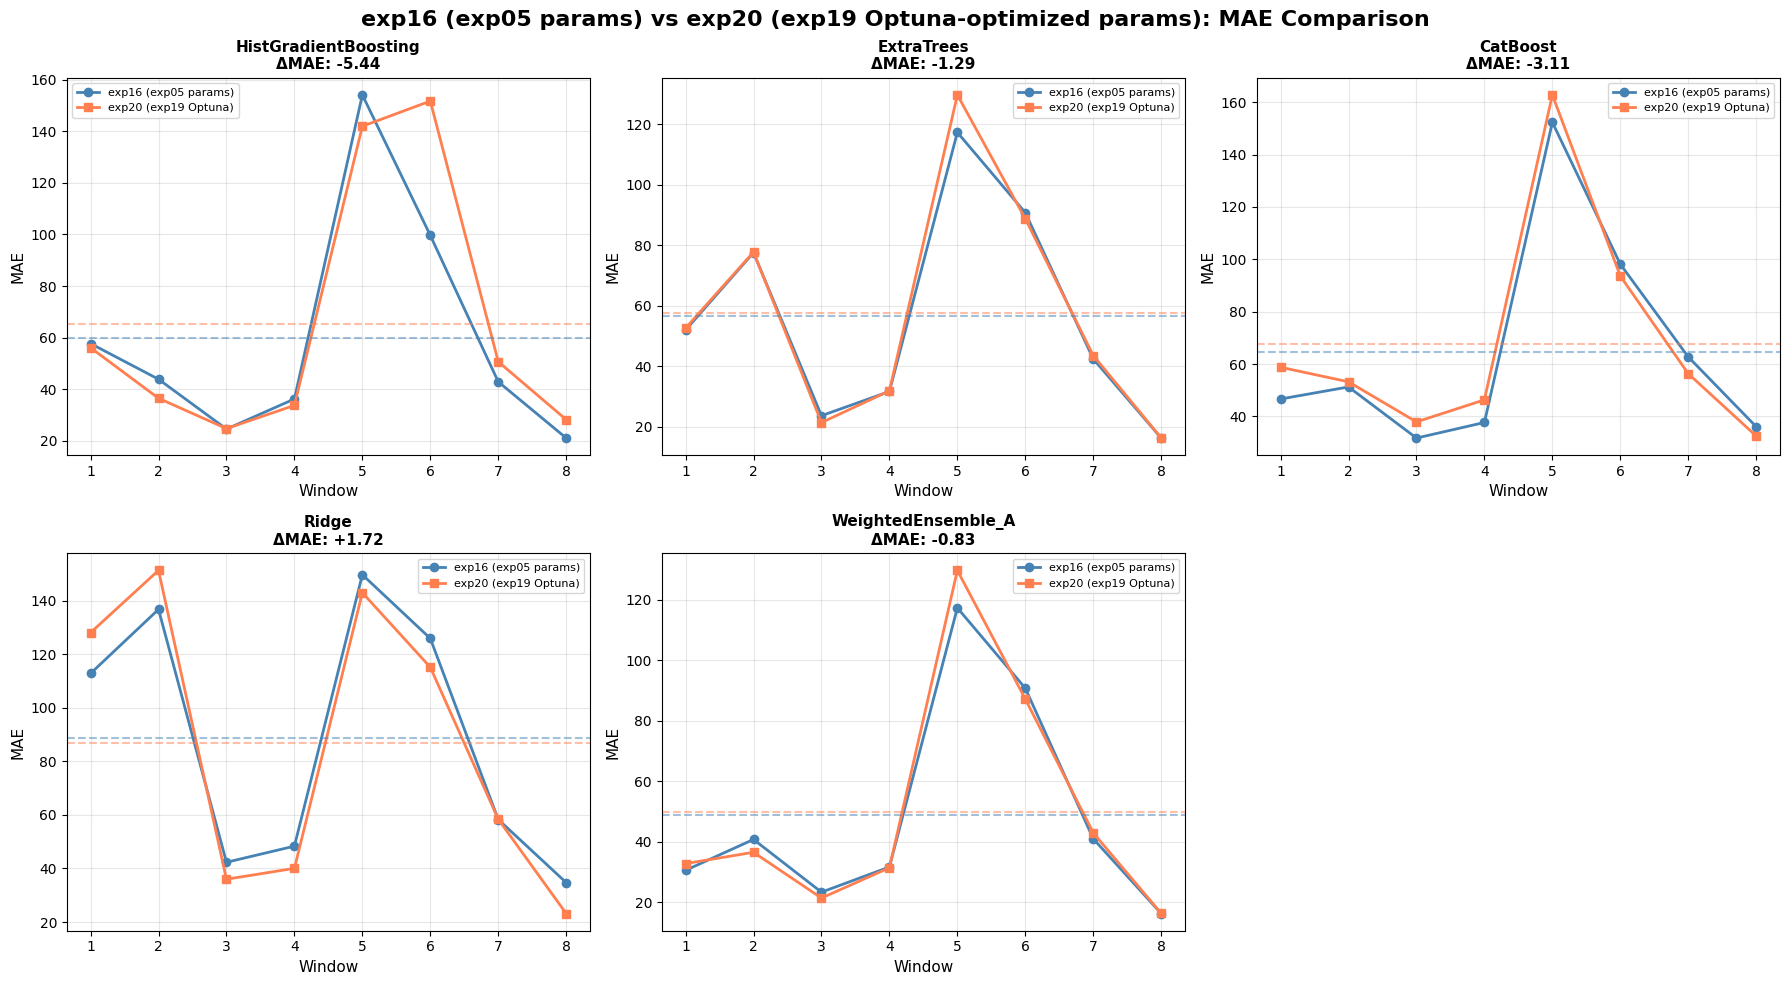


可視化を保存しました: ../output/exp20/exp16_vs_exp20_comparison.png


In [10]:
# ============================================================================
# 可視化: exp16 vs exp20 比較
# ============================================================================

import matplotlib.pyplot as plt

if os.path.exists(exp16_results_path):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('exp16 (exp05 params) vs exp20 (exp19 Optuna-optimized params): MAE Comparison', 
                 fontsize=16, fontweight='bold')
    
    models_to_compare = ['HistGradientBoosting', 'ExtraTrees', 'CatBoost', 'Ridge', 'WeightedEnsemble_A']
    
    for idx, model in enumerate(models_to_compare):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]
        
        exp16_model_data = exp16_results_df[exp16_results_df['model'] == model]
        exp20_model_data = exp20_results_df[exp20_results_df['model'] == model]
        
        ax.plot(exp16_model_data['window'], exp16_model_data['MAE'], 
                marker='o', label='exp16 (exp05 params)', linewidth=2, color='steelblue')
        ax.plot(exp20_model_data['window'], exp20_model_data['MAE'], 
                marker='s', label='exp20 (exp19 Optuna)', linewidth=2, color='coral')
        
        # 平均MAEを表示
        exp16_avg = exp16_model_data['MAE'].mean()
        exp20_avg = exp20_model_data['MAE'].mean()
        improvement = exp16_avg - exp20_avg
        
        ax.axhline(y=exp16_avg, color='steelblue', linestyle='--', alpha=0.5)
        ax.axhline(y=exp20_avg, color='coral', linestyle='--', alpha=0.5)
        
        ax.set_xlabel('Window', fontsize=11)
        ax.set_ylabel('MAE', fontsize=11)
        ax.set_title(f'{model}\nΔMAE: {improvement:+.2f}', fontsize=11, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)
        ax.set_xticks(range(1, len(windows) + 1))
    
    # 空の6番目のサブプロットを削除
    fig.delaxes(axes[1, 2])
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/exp16_vs_exp20_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n可視化を保存しました: {output_dir}/exp16_vs_exp20_comparison.png")
else:
    print("\nexp16の結果が見つからないため、比較可視化をスキップします。")

---

## Summary

**exp20: exp19の最適化パラメータをRolling Window Validationで評価**

### 目的:
- exp19でOptunaにより最適化されたパラメータを使用
- exp16と同じRolling Window Validation（8ウィンドウ）で評価
- 検証方法を統一して公正な比較を実現

### ベースライン:
- exp16 (WeightedEnsemble_A MAE=48.98)
- exp05で最適化されたパラメータを使用

### exp20の最適化:
- exp19でOptunaにより再最適化（各モデル100 trials）
- exp16の特徴量セット（50個）に対して最適化

### 検証結果:
- exp16との比較でMAEの改善/悪化を確認
- Optunaパラメータ最適化の効果を定量化

### 出力ファイル:
1. `rolling_window_results.csv` - 全ウィンドウの詳細結果
2. `average_scores.csv` - モデルごとの平均スコア
3. `std_scores.csv` - モデルごとの標準偏差（安定性）
4. `exp16_vs_exp20_comparison.png` - 可視化

In [11]:
# exp20のcell-8を以下のように修正すると重みが確認できます

# ============================================================================
# Rolling Window Validation の実行（exp19の最適化パラメータを使用）
# + WeightedEnsemble_Aの重みを保存
# ============================================================================

from sklearn.linear_model import Ridge
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from scipy.optimize import minimize

all_window_results = []
all_ensemble_weights = []  # 🔥 NEW: 各ウィンドウの重みを保存

print("\n" + "=" * 80)
print("Rolling Window Validation 実行（exp19最適化パラメータ）")
print("=" * 80)

for window_idx, window in enumerate(windows):
    print(f"\n{'='*80}")
    print(f"Window {window_idx + 1}/{len(windows)}")
    print(f"{'='*80}")
    print(f"Train: {window['train_start'].strftime('%Y-%m-%d')} ~ {window['train_end'].strftime('%Y-%m-%d')}")
    print(f"Test : {window['test_start'].strftime('%Y-%m-%d')} ~ {window['test_end'].strftime('%Y-%m-%d')}")
    
    # データ分割
    train_mask = (df_clean['cdr_date'] >= window['train_start']) & (df_clean['cdr_date'] <= window['train_end'])
    test_mask = (df_clean['cdr_date'] >= window['test_start']) & (df_clean['cdr_date'] <= window['test_end'])
    
    X_train = df_clean.loc[train_mask, feature_cols]
    y_train = df_clean.loc[train_mask, 'target_next_day']
    X_test = df_clean.loc[test_mask, feature_cols]
    y_test = df_clean.loc[test_mask, 'target_next_day']
    
    print(f"\nTrain: {len(X_train)}件, Test: {len(X_test)}件")
    
    # 各モデルの訓練と評価
    window_models = {}
    window_predictions = {}
    
    # 1. HistGradientBoosting（exp19パラメータ）
    print("\n[1/5] HistGradientBoosting（exp19最適化）...")
    hist_model = HistGradientBoostingRegressor(**OPTIMIZED_PARAMS_EXP19['HistGradientBoosting'], random_state=42)
    hist_model.fit(X_train, y_train)
    hist_pred = hist_model.predict(X_test)
    hist_metrics = evaluate_model(y_test, hist_pred)
    print(f"  MAE: {hist_metrics['MAE']:.2f}, RMSE: {hist_metrics['RMSE']:.2f}, R2: {hist_metrics['R2']:.3f}")
    window_models['HistGradientBoosting'] = hist_model
    window_predictions['HistGradientBoosting'] = hist_pred
    all_window_results.append({'window': window_idx+1, 'model': 'HistGradientBoosting', **hist_metrics})
    
    # 2. ExtraTrees（exp19パラメータ）
    print("[2/5] ExtraTrees（exp19最適化）...")
    extra_model = ExtraTreesRegressor(**OPTIMIZED_PARAMS_EXP19['ExtraTrees'], random_state=42, n_jobs=-1)
    extra_model.fit(X_train, y_train)
    extra_pred = extra_model.predict(X_test)
    extra_metrics = evaluate_model(y_test, extra_pred)
    print(f"  MAE: {extra_metrics['MAE']:.2f}, RMSE: {extra_metrics['RMSE']:.2f}, R2: {extra_metrics['R2']:.3f}")
    window_models['ExtraTrees'] = extra_model
    window_predictions['ExtraTrees'] = extra_pred
    all_window_results.append({'window': window_idx+1, 'model': 'ExtraTrees', **extra_metrics})
    
    # 3. CatBoost（exp19パラメータ）
    print("[3/5] CatBoost（exp19最適化）...")
    catboost_model = CatBoostRegressor(**OPTIMIZED_PARAMS_EXP19['CatBoost'], random_state=42, verbose=0)
    catboost_model.fit(X_train, y_train)
    catboost_pred = catboost_model.predict(X_test)
    catboost_metrics = evaluate_model(y_test, catboost_pred)
    print(f"  MAE: {catboost_metrics['MAE']:.2f}, RMSE: {catboost_metrics['RMSE']:.2f}, R2: {catboost_metrics['R2']:.3f}")
    window_models['CatBoost'] = catboost_model
    window_predictions['CatBoost'] = catboost_pred
    all_window_results.append({'window': window_idx+1, 'model': 'CatBoost', **catboost_metrics})
    
    # 4. Ridge（exp19パラメータ）
    print("[4/5] Ridge（exp19最適化）...")
    ridge_model = Ridge(**OPTIMIZED_PARAMS_EXP19['Ridge'], random_state=42)
    ridge_model.fit(X_train, y_train)
    ridge_pred = ridge_model.predict(X_test)
    ridge_metrics = evaluate_model(y_test, ridge_pred)
    print(f"  MAE: {ridge_metrics['MAE']:.2f}, RMSE: {ridge_metrics['RMSE']:.2f}, R2: {ridge_metrics['R2']:.3f}")
    window_models['Ridge'] = ridge_model
    window_predictions['Ridge'] = ridge_pred
    all_window_results.append({'window': window_idx+1, 'model': 'Ridge', **ridge_metrics})
    
    # 5. Weighted Ensemble A（各ウィンドウで重み最適化）
    print("[5/5] WeightedEnsemble_A（Testセットで重み最適化）...")
    
    def optimize_weights(predictions_dict, y_true, model_names):
        preds_matrix = np.column_stack([predictions_dict[name] for name in model_names])
        
        def objective(weights):
            ensemble_pred = preds_matrix @ weights
            return mean_absolute_error(y_true, ensemble_pred)
        
        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}
        bounds = [(0, 1) for _ in range(len(model_names))]
        initial_weights = np.ones(len(model_names)) / len(model_names)
        
        result = minimize(objective, initial_weights, method='SLSQP',
                         bounds=bounds, constraints=constraints)
        return result.x
    
    pattern_a_models = ['Ridge', 'CatBoost', 'ExtraTrees', 'HistGradientBoosting']
    weights_a = optimize_weights(window_predictions, y_test, pattern_a_models)
    
    # 🔥 NEW: 重みを表示・保存
    print("\n  最適化された重み:")
    for model_name, weight in zip(pattern_a_models, weights_a):
        print(f"    {model_name}: {weight:.4f}")
    
    # 重みをリストに追加
    weight_dict = {'window': window_idx+1}
    for model_name, weight in zip(pattern_a_models, weights_a):
        weight_dict[model_name] = weight
    all_ensemble_weights.append(weight_dict)
    
    weightA_pred = np.column_stack([window_predictions[name] for name in pattern_a_models]) @ weights_a
    weightA_metrics = evaluate_model(y_test, weightA_pred)
    print(f"\n  MAE: {weightA_metrics['MAE']:.2f}, RMSE: {weightA_metrics['RMSE']:.2f}, R2: {weightA_metrics['R2']:.3f}")
    all_window_results.append({'window': window_idx+1, 'model': 'WeightedEnsemble_A', **weightA_metrics})

print("\n" + "=" * 80)
print("Rolling Window Validation 完了")
print("=" * 80)

# 🔥 NEW: 重みの要約を表示
print("\n" + "=" * 80)
print("WeightedEnsemble_A: 各ウィンドウの重み")
print("=" * 80)
weights_df = pd.DataFrame(all_ensemble_weights)
print(weights_df.to_string(index=False))

# 平均重み
print("\n平均重み:")
for col in pattern_a_models:
    avg_weight = weights_df[col].mean()
    print(f"  {col}: {avg_weight:.4f}")


Rolling Window Validation 実行（exp19最適化パラメータ）

Window 1/8
Train: 2018-07-02 ~ 2018-11-28
Test : 2018-11-29 ~ 2019-01-28

Train: 108件, Test: 43件

[1/5] HistGradientBoosting（exp19最適化）...
  MAE: 56.12, RMSE: 77.62, R2: -0.332
[2/5] ExtraTrees（exp19最適化）...
  MAE: 52.63, RMSE: 77.83, R2: -0.340
[3/5] CatBoost（exp19最適化）...
  MAE: 58.79, RMSE: 69.88, R2: -0.080
[4/5] Ridge（exp19最適化）...
  MAE: 128.08, RMSE: 154.65, R2: -4.289
[5/5] WeightedEnsemble_A（Testセットで重み最適化）...

  最適化された重み:
    Ridge: 0.2824
    CatBoost: 0.6676
    ExtraTrees: 0.0500
    HistGradientBoosting: 0.0000

  MAE: 32.80, RMSE: 39.10, R2: 0.662

Window 2/8
Train: 2018-07-02 ~ 2019-01-28
Test : 2019-01-29 ~ 2019-03-30

Train: 151件, Test: 44件

[1/5] HistGradientBoosting（exp19最適化）...
  MAE: 36.53, RMSE: 45.99, R2: 0.398
[2/5] ExtraTrees（exp19最適化）...
  MAE: 77.80, RMSE: 93.05, R2: -1.463
[3/5] CatBoost（exp19最適化）...
  MAE: 53.22, RMSE: 59.54, R2: -0.008
[4/5] Ridge（exp19最適化）...
  MAE: 151.32, RMSE: 182.18, R2: -8.442
[5/5] WeightedE